# Portfolio Optimization Using Python

Many indviduals use 401Ks and different retirement tools to help prepare for life after work. Many of these tools depend on managing risk appropiately as to not incure large losses while still taking necessary risk to grow the initial capital. In this series, we will cover the topic of portfolio optimization, a popular technique that financial and investment advisors use to help ensure that their clients are taking appropriate risk to meet their financial objectives.

This tutorial will be broken into a few different sections with each section buildin on top of each other. The first section we will focus on collecting the data necessary for analysis. The data will be pretty simple, just closing price data for a small portfolio of stocks. While in this tutorial, I will focus on using the NASDAQ as my source of data I will be providing different ways on how to get this data in some supplementary code.

After we cover collecting the data, we will then move through the process of preparing the data to calculate a few different metrics that will be crucial for optaining optimial results in our portfolio. A few metrics we will calculate are expected returns, expected volatility, and the Sharpe Ratio. Once we have these metrics defined, we will then move into the process of building a simulation that will randomly generate results that we can use to help determine the optimial results for a wide range of portfolios.

We will take the results of this simulation, plot them using `matplotlib`, and then explore how we can use the `scipy` library to run an optimization algorthim that will return the best weights for our simulation.

In [126]:
import pathlib
import numpy as np
import pandas as pd
pd.options.display.max_seq_items = 2000
import matplotlib.pyplot as plt
import scipy.optimize as sci_opt

from fake_useragent import UserAgent
from pprint import pprint
from sklearn.preprocessing import StandardScaler
from pyopt.client import PriceHistory

# Set some display options for Panda

In [127]:
# Define the symbols
symbols = ['AAPL', 'MSFT', 'SQ','NVDA']

# At different points, we will need to generate metrics based on the number
# of symbols we have, so let's save some time and just calculate that now.
number_of_symbols = len(symbols)

# If we don't have data then grab it.
if not pathlib.Path('C:\\Users\\aakar\\OneDrive\\Desktop\\portfolio-optimization-master\\data\\stock_data.csv').exists():

    # Initialize the client.
    price_history_client = PriceHistory(symbols=symbols,user_agent=UserAgent().edge)

    # Dump it to a CSV file.
    price_history_client.price_data_frame.to_csv(
        r'C:\Users\aakar\OneDrive\Desktop\portfolio-optimization-master\data\stock_data.csv',
        index=False
    )
    display(price_history_client.price_data_frame)

    # Grab the data frame.
    price_data_frame: pd.DataFrame = price_history_client.price_data_frame

else:

    # Load the data.
    price_data_frame: pd.DataFrame = pd.read_csv('C:\\Users\\aakar\\OneDrive\\Desktop\\portfolio-optimization-master\\data\\stock_data.csv')

# Print the head.
display(price_data_frame)


,date,close,volume,open,high,low,symbol
0,2024-09-06,102.83,413638100,108.040,108.15,100.9500,NVDA
1,2024-09-05,107.21,306850700,104.985,109.65,104.7600,NVDA
2,2024-09-04,106.21,372470300,105.410,113.27,104.1200,NVDA
3,2024-09-03,108.00,477155100,116.010,116.21,107.2900,NVDA
4,2024-08-30,119.37,333751600,119.530,121.75,117.2200,NVDA
...,...,...,...,...,...,...,...
2003,2022-09-14,155.31,87965410,154.785,157.10,153.6106,AAPL
2004,2022-09-13,153.84,122656600,159.900,160.54,153.3700,AAPL
2005,2022-09-12,163.43,104956000,159.590,164.26,159.3000,AAPL
2006,2022-09-09,157.37,68081010,155.470,157.82,154.7500,AAPL


The data is pretty close to what we need, but it needs a little bit more massaging before we can jump to the next steps. We can use the `pivot` method to reorganize the data so that we have a single column for each symbol, where each column contains the close price. By having the data like this, we can then calculate the returns for each day.

In [128]:
# Since we don't need all the data, let's limit the columns we need to work with.
price_data_frame = price_data_frame[['date', 'symbol', 'close']]

# Once we've done that, use the `pivot` method to reorganize the data. Have the `date`
# be our new index, the `symbols` as our columns, and the `close` price as our values.
price_data_frame = price_data_frame.pivot(
    index='date',
    columns='symbol',
    values='close'
)
display(price_data_frame)

symbol,AAPL,MSFT,NVDA,SQ
date,,,,
2022-09-08,154.46,258.52,13.990,70.59
2022-09-09,157.37,264.46,14.387,74.29
2022-09-12,163.43,266.65,14.505,75.25
2022-09-13,153.84,251.99,13.131,69.58
2022-09-14,155.31,252.22,13.128,68.56
...,...,...,...,...
2024-08-30,229.00,417.14,119.370,66.08
2024-09-03,222.77,409.44,108.000,64.17
2024-09-04,220.85,408.90,106.210,64.08


I think this is a good point to start talking about some of the next steps we are going to do. However, I find it helps to have a high-level overview of the goal, and the tools we will be using to get there. Now at this point, you should recognize that we are using to portfolio of stocks to help generate returns. However, to generate these returns we need to take on **risk**, but ideally we should be comfortable taking on this risk because we are compensated in the form returns that increase our investment.

However, most investors aren't okay with taking on high-levels of risk, so our goal is to find the best ratio of risk vs returns. Ideally, we are taking the most risk we are comfortable with and attempting to maximize those returns. That naturally leads to an important question, "How do we measure risk?". Well, this can lead you down a rabbit hole because there are many ways to measure risk and some are more appropriate than others depending on the situation at hand. In our case, we will use a very popular metric, the `Sharpe Ratio`. The Sharpe Ratio, is used is a measure for calculating risk-adjusted return and has been the industry standard for such calculations. The Sharpe Ratio allows us to quantify the relationship the average return earned in excess of the risk-free rate per unit of volatility or total risk.

Mathematically, we define the Sharpe Ratio as the following:

\begin{equation*}
\text{Sharpe Ratio} = \frac{(R_p - R_f)}{\sigma_p}
\end{equation*}

Where:

$
\begin{align}
\ R_p & = \text{Return of Portfolio} \\
\ R_f & = \text{Risk-Free Rate} \\
\ \sigma_p & = \text{Standard Deviation of Portfolio's Excess Return} \\
\end{align}
$

To calculate the expected returns, we use the following formula:

\begin{equation*}
\ R_p = (w_{1}r_{1}) + (w_{2}r_{2}) + \cdots + (w_{n}r_{n})
\end{equation*}

Where:

$
\begin{align}
\ r_{i} & = \text{Return of Security i} \\
\ w_{i} & = \text{Weight of Security i} \\
\end{align}
$

To calculate the standard deviation of the protfolio, we use the following formula:

\begin{equation*}
\ \sigma_p = \sqrt{(w_{i}^2 \sigma_i^2) + (w_{j}^2 \sigma_j^2) + (2w_{j}w_{i} p_{i,j} \sigma_i \sigma_j)}
\end{equation*}

Where:

$
\begin{align}
\ \sigma_{i} & = \text{Standard Deviation of Returns for Security i} \\
\ w_{i} & = \text{Weight of Security i} \\
\ p_{i,j} & = \text{Correlation Coefficent between the returns of asset i and asset j} \\
\end{align}
$

In [129]:
# Calculate the Log of returns.
log_return = np.log(1 + price_data_frame.pct_change())


# Generate Random Weights.
random_weights = np.array(np.random.random(number_of_symbols))

# Generate the Rebalance Weights, these should equal 1.
rebalance_weights = random_weights / np.sum(random_weights)




# Calculate the Expected Returns, annualize it by multiplying it by `252`.
exp_ret = np.sum((log_return.mean() * rebalance_weights) * 252)

# Calculate the Expected Volatility, annualize it by multiplying it by `252`.
exp_vol = np.sqrt(
np.dot(
    rebalance_weights.T,
    np.dot(
        log_return.cov() * 252,
        rebalance_weights
    )
)
)

# Calculate the Sharpe Ratio.
sharpe_ratio = exp_ret / exp_vol

# Put the weights into a data frame to see them better.
weights_df = pd.DataFrame(data={
'random_weights': random_weights,
'rebalance_weights': rebalance_weights
})
print('')
print('='*80)
print('PORTFOLIO WEIGHTS:')
print('-'*80)
print(weights_df)
print('-'*80)

# Do the same with the other metrics.
metrics_df = pd.DataFrame(data={
    'Expected Portfolio Returns': exp_ret,
    'Expected Portfolio Volatility': exp_vol,
    'Portfolio Sharpe Ratio': sharpe_ratio
}, index=[0])

print('')
print('='*80)
print('PORTFOLIO METRICS:')
print('-'*80)
print(metrics_df)
print('-'*80)


PORTFOLIO WEIGHTS:
--------------------------------------------------------------------------------
   random_weights  rebalance_weights
0        0.179227           0.106223
1        0.554957           0.328909
2        0.231098           0.136966
3        0.721984           0.427902
--------------------------------------------------------------------------------

PORTFOLIO METRICS:
--------------------------------------------------------------------------------
   Expected Portfolio Returns  Expected Portfolio Volatility  \
0                    0.198852                       0.341273   

   Portfolio Sharpe Ratio  
0                0.582677  
--------------------------------------------------------------------------------


# Portfolio Optimization: Monte Carlo

Great, so we now have a way to evaluate how well our portfolio is allocated. It involves, calculating the expected returns, the expected volatility, and then from here we use the Sharpe Ratio to quantify how well our portfolio is allocated based on a risk perspective. The big question here is, "If we know that we want to get a higher sharpe ratio, what is the portfolio allocation we need to achieve this?"

Well, there are two ways to approach this. First, we could test a bunch of different random allocations and see which ones produces the highest Sharpe Ratio. Second, we could use mathematical optimization defined by some constrains to arrive at the optimial allocation. In the next section, we will run the "try a bunch of random allocations" method. Now, there is a more formal name for this process, a Monte Carlo Simulation.

**Monte Carlo simulations are used to model the probability of different outcomes in a process that cannot easily be predicted due to the intervention of random variables. It is a technique used to understand the impact of risk and uncertainty in prediction and forecasting models.**

To do this in python, we will do is run the process we laid out up above and run it a couple thousands of time, and store the results of each run in a data frame. Once we've completed each run, we will find the allocations that produce the highest Sharpe Ratio and the lowest Volatility.

In [131]:
# Initialize the components, to run a Monte Carlo Simulation.

# We will run 5000 iterations.
num_of_portfolios = 5000

# Prep an array to store the weights as they are generated, 5000 iterations for each of our 4 symbols.
all_weights = np.zeros((num_of_portfolios, number_of_symbols))



# Prep an array to store the returns as they are generated, 5000 possible return values.
ret_arr = np.zeros(num_of_portfolios)



# Prep an array to store the volatilities as they are generated, 5000 possible volatility values.
vol_arr = np.zeros(num_of_portfolios)

# Prep an array to store the sharpe ratios as they are generated, 5000 possible Sharpe Ratios.
sharpe_arr = np.zeros(num_of_portfolios)

# Start the simulations.
for ind in range(num_of_portfolios):

    # First, calculate the weights.
    weights = np.array(np.random.random(number_of_symbols))
    weights = weights / np.sum(weights)

    # Add the weights, to the `weights_arrays`.
    all_weights[ind, :] = weights

    # Calculate the expected log returns, and add them to the `returns_array`.
    ret_arr[ind] = np.sum((log_return.mean() * weights) * 252)

    # Calculate the volatility, and add them to the `volatility_array`.
    vol_arr[ind] = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
    )

    # Calculate the Sharpe Ratio and Add it to the `sharpe_ratio_array`.
    sharpe_arr[ind] = ret_arr[ind]-.01/vol_arr[ind]

# Let's create our "Master Data Frame", with the weights, the returns, the volatility, and the Sharpe Ratio
simulations_data = [ret_arr, vol_arr, sharpe_arr, all_weights]

# Create a DataFrame from it, then Transpose it so it looks like our original one.
simulations_df = pd.DataFrame(data=simulations_data).T

# Give the columns the Proper Names.
simulations_df.columns = [
    'Returns',
    'Volatility',
    'Sharpe Ratio',
    'Portfolio Weights'
]

# Make sure the data types are correct, we don't want our floats to be strings.
simulations_df = simulations_df.infer_objects()

# Print out the results.
print('')

print('SIMULATIONS RESULT:')

display(simulations_df.head())



SIMULATIONS RESULT:
----------------------------------------------------------------------------------------------------


,Returns,Volatility,Sharpe Ratio,Portfolio Weights
0,0.626819,0.358071,0.598892,"[0.268843737526197, 0.1731698698905346, 0.5396..."
1,0.139392,0.296765,0.105695,"[0.39811846187959127, 0.22604138675548416, 0.0..."
2,0.530237,0.368996,0.503136,"[0.10431405194783774, 0.20508986756722208, 0.4..."
3,0.339889,0.367597,0.312686,"[0.2613789832372976, 0.029386465511077018, 0.3..."
4,0.439053,0.398918,0.413985,"[0.14359257038671397, 0.02952542586563754, 0.4..."


----------------------------------------------------------------------------------------------------


# Grab the Important Metrics
Okay now that we ran our simulation let's take a look at some interesting metrics. The first one, we can take a look at is the `max_sharpe_ratio`, this is Sharpe Ratio where the excess return of the portfolio is greatest given the amount of risk we are taking on. In other words, these portfolios are "best" because they provide the largest risk-adjusted returns. The next metric is the `min_volatiltiy`, these are the weights where the overall volatility of the portfolio is at it's lowest. In other words, if you want to take on the least amount of risk, these are the weights you would want to have. 

**Note, where do these numbers end up in our next section where we plot our data?**

In [124]:
# Return the Max Sharpe Ratio from the run.
max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]

# Return the Min Volatility from the run.
min_volatility = simulations_df.loc[simulations_df['Volatility'].idxmin()]

print('')
print('='*80)
print('MAX SHARPE RATIO:')
print('-'*80)
display(max_sharpe_ratio)
print('-'*80)

print('')
print('='*80)
print('MIN VOLATILITY:')
print('-'*80)
display(min_volatility)
print('-'*80)


MAX SHARPE RATIO:
--------------------------------------------------------------------------------


Returns                                                       0.938905
Volatility                                                    0.505579
Sharpe Ratio                                                  0.919125
Portfolio Weights    [0.01838983340519889, 0.004999450308866329, 0....
Name: 2799, dtype: object

--------------------------------------------------------------------------------

MIN VOLATILITY:
--------------------------------------------------------------------------------


Returns                                                       0.210749
Volatility                                                     0.23449
Sharpe Ratio                                                  0.168103
Portfolio Weights    [0.5298838825346158, 0.45343503388739154, 0.01...
Name: 3270, dtype: object

--------------------------------------------------------------------------------


# Plotting:

Now producing a bunch of different weights is one thing, but it helps to see the results of our simulation using a graph. We will use `matplotlib` to create a scatter plot that shows the relationship between the overall volatility of our portfolio, and the expected returns from it. Ideally, what we should see is that as we take on more risk, we should be getting higher risk-adjusted returns. The opposite can be said for volaility, the less volatility we take on the lower the expected return we should be getting.

Now as mentioned above, where does the `minimum_volatility` and the `maximum_sharpe_ratio` fall on this grab? Hint, lower volatility means lower risk-adjusted returns.

C:\Users\aakar\AppData\Local\Temp\ipykernel_24276\563608600.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_sharpe_ratio[1],
C:\Users\aakar\AppData\Local\Temp\ipykernel_24276\563608600.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_sharpe_ratio[0],
C:\Users\aakar\AppData\Local\Temp\ipykernel_24276\563608600.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_volatility[1],
C:\Users\aakar\AppData\Local\Temp\ip

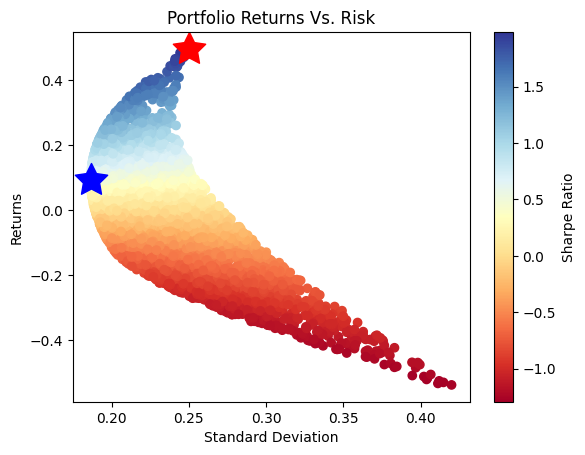

In [16]:
# This is so I can see the plot inside of my Jupyter Notebook.
%matplotlib inline

# Plot the data on a Scatter plot.
plt.scatter(
    y=simulations_df['Returns'],
    x=simulations_df['Volatility'],
    c=simulations_df['Sharpe Ratio'],
    cmap='RdYlBu'
)

# Give the Plot some labels, and titles.
plt.title('Portfolio Returns Vs. Risk')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')

# Plot the Max Sharpe Ratio, using a `Red Star`.
plt.scatter(
    max_sharpe_ratio[1],
    max_sharpe_ratio[0],
    marker=(5, 1, 0),
    color='r',
    s=600
)

# Plot the Min Volatility, using a `Blue Star`.
plt.scatter(
    min_volatility[1],
    min_volatility[0],
    marker=(5, 1, 0),
    color='b',
    s=600
)

# Finally, show the plot.
plt.show()

# Optimization

Alright, now remember that up above I mentioned that we would be exploring multiple ways to optimize our portfolio. The first was using Monte Carlo Simulation that would try thousands of random values and find the best values. The draw back to using the Monte Carlo Simulation is that it's not the most efficent way to find the optimial values. Instead we can use mathematical techniques to easily arrive at the optimial values.

To help run this new optimization method, we will need to define a few more functions that we will use in our method. The first function is the `get_metrics()` function which will return the metrics for a given set of weights provided. In other words, think of it as a "lookup function" where we can return the results of a certain weight. The second function is the `neg_sharpe` function which is used as a minimization function. The minimization function is used to help find the values which results in the lowest sharpe ratio. In Scipy’s optimize function, there’s no `maximize`, so as an objective function you need to pass something that should be minimized.

The third function is `check_sum` function which is used as a constraint. What is will do is make sure that the weights that are passed through meet the constraint that we must have a portfolio allocation equal 100%, not more and not less.

In [17]:
def get_metrics(weights: list) -> np.array:
    """
    ### Overview:
    ----
    With a given set of weights, return the portfolio returns,
    the portfolio volatility, and the portfolio sharpe ratio.

    ### Arguments:
    ----
    weights (list): An array of portfolio weights.

    ### Returns:
    ----
    (np.array): An array containg return value, a volatility value,
        and a sharpe ratio.
    """

    # Convert to a Numpy Array.
    weights = np.array(weights)

    # Calculate the returns, remember to annualize them (252).
    ret = np.sum(log_return.mean() * weights) * 252

    # Calculate the volatility, remember to annualize them (252).
    vol = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
    )

    # Calculate the Sharpe Ratio.
    sr = ret / vol

    return np.array([ret, vol, sr])

def grab_negative_sharpe(weights: list) -> np.array:
    """The function used to minimize the Sharpe Ratio.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.
    """
    return get_metrics(weights)[2] - 1

def grab_volatility(weights: list) -> np.array:
    """The function used to minimize the Sharpe Ratio.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.
    """
    return get_metrics(weights)[1]

def check_sum(weights: list) -> float:
    """Ensure the allocations of the "weights", sums to 1 (100%)

    ### Arguments:
    ----
    weights (list): The weights we want to check to see
        if they sum to 1.

    ### Returns:
    ----
    float: The different between 1 and the sum of the weights.
    """
    return np.sum(weights) - 1

Okay with our functions now defined, let's run the optimization using the `scipy.optimization` module. This module has a function called `minimize` which we can use to help our optimial values. However, we need to do a few things before we run it. First, we need to define bounds which tells the minimize function that each of our positions can only be between 0% and 100% of the allocation. Second, we need to define the constraint which will be a `fun`(function) that ensures we `equ`(equal) a 100% allocated portfolio. In other words, we use all the "capital" we can. Third, we need to define our initial guess of the weights. The initial guess can be anything but in this case let's make it easy and start with an equally distirbuted portofolio. In this case we have 4 symbols so each symbol will be 25% of the portfolio.

Once we've define this steps we can run the optimization by passing through the arguments defined and defining the `method` as `SLSQP` which is short for `Sequential Least Squares Programming`. Now, the different optimization methods are a whole different topic and is outside the scope of this tutorial. Once we run the `minimize` method we can grab the results.

The first is the results of our minimization operation. Inside the results, you'll see the optimize sharpe ration defined by the `fun` value. We can then take the `optimized_weights` defined by the `optimized_sharpe.x` values, and use them to return the different metrics we have for our portfolio.

In [18]:
# Define the boundaries for each symbol. Remember I can only invest up to 100% of my capital into a single asset.
bounds = tuple((0, 1) for symbol in range(number_of_symbols))

# Define the constraints, here I'm saying that the sum of each weight must not exceed 100%.
constraints = ({'type': 'eq', 'fun': check_sum})

# We need to create an initial guess to start with,
# and usually the best initial guess is just an
# even distribution. In this case 25% for each of the 4 stocks.
init_guess = number_of_symbols * [1 / number_of_symbols]

# Perform the operation to minimize the risk.
optimized_sharpe = sci_opt.minimize(
    grab_negative_sharpe, # minimize this.
    init_guess, # Start with these values.
    method='SLSQP',
    bounds=bounds, # don't exceed these bounds.
    constraints=constraints # make sure you don't exceed the 100% constraint.
)

# Print the results.
print('')
print('='*80)
print('OPTIMIZED SHARPE RATIO:')
print('-'*80)
print(optimized_sharpe)
print('-'*80)


OPTIMIZED SHARPE RATIO:
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -2.3016256275296536
       x: [ 0.000e+00  1.055e-15  1.000e+00]
     nit: 2
     jac: [ 1.416e+00  1.270e-01 -0.000e+00]
    nfev: 8
    njev: 2
--------------------------------------------------------------------------------


In [19]:
# Grab the metrics.
optimized_metrics = get_metrics(weights=optimized_sharpe.x)

# Print the Optimized Weights.
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_sharpe.x)
print('-'*80)


# Print the Optimized Metrics.
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_metrics)
print('-'*80)


OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[0.00000000e+00 1.05471187e-15 1.00000000e+00]
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
--------------------------------------------------------------------------------
[-0.55729003  0.42814924 -1.30162563]
--------------------------------------------------------------------------------


In [20]:
# Define the boundaries for each symbol. Remember I can only invest up to 100% of my capital into a single asset.
bounds = tuple((0, 1) for symbol in range(number_of_symbols))

# Define the constraints, here I'm saying that the sum of each weight must not exceed 100%.
constraints = ({'type': 'eq', 'fun': check_sum})

# We need to create an initial guess to start with,
# and usually the best initial guess is just an
# even distribution. In this case 25% for each of the 4 stocks.
init_guess = number_of_symbols * [1 / number_of_symbols]

# Perform the operation to minimize the risk.
optimized_volatility = sci_opt.minimize(
    grab_volatility, # minimize this.
    init_guess, # Start with these values.
    method='SLSQP',
    bounds=bounds, # don't exceed these bounds.
    constraints=constraints # make sure you don't exceed the 100% constraint.
)

# Print the results.
print('')
print('='*80)
print('OPTIMIZED VOLATILITY RATIO:')
print('-'*80)
print(optimized_volatility)
print('-'*80)


OPTIMIZED VOLATILITY RATIO:
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.1865765273392647
       x: [ 2.634e-01  6.820e-01  5.457e-02]
     nit: 8
     jac: [ 1.865e-01  1.866e-01  1.868e-01]
    nfev: 32
    njev: 8
--------------------------------------------------------------------------------


In [21]:
# Grab the metrics.
optimized_metrics = get_metrics(weights=optimized_volatility.x)

# Print the Optimized Weights.
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_volatility.x)
print('-'*80)


# Print the Optimized Metrics.
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_metrics)
print('-'*80)


OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[0.26341729 0.68201297 0.05456974]
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
--------------------------------------------------------------------------------
[0.09082431 0.18657653 0.48679387]
--------------------------------------------------------------------------------
